<h1>Monte Carlo Simulations of Ising Model 2D</h1>

<p>As a start let us briefly summarize the Ising Model. The model have the following Hamiltonian:
    $$ H(\sigma) = -\sum_{<i,j>} J_{ij}\sigma_i \sigma_j - h\sum_j \sigma_j$$ and the magnetizations is defined to be:
    $$ m = \frac{1}{N} \sum_i \sigma_i$$ where N is the total number of sites.</p>

<h2>Implementation of the IsingModel Class</h2>
<p>This class will help us easily create Ising Models so that our Monte Carlo Simulations would be easier to implement.</p>

<p>As a reminder for the different values of parameters, the configurations that we may expect is as follows: $$ J_{ij} > 0: \text{ferromagnetic configuration}$$
$$ J_{ij} = 0: \text{non-interacting}$$
$$ J_{ij} < 0: \text{anti-ferromagnetic configuration}$$ and for the other parameter:
$$ h>0: \text{tends to line up in the positive direction}$$
$$ h<0: \text{tends to line up in the negative direction}$$
</p>

<p>We start by importing and initializing the class. Then we will have some methods for IsingModel objects. Some of the methods will be more generic such as printing the object properly, and some will be more technical such as energy of the object. We will have the following methods:
    <ul>
        <li>Initializing instant</li>
        <li>Plotting the lattice</li>
        <li>Flipping the spin</li>
        <li>Energy of the spin in one lattice point</li>
        <li>Critical Temperature</li>
        <li>Magnetization</li>
        <li>Calculate energy of the lattice per spin</li>
        <li>Print all the information about the object</li>
    </ul></p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle as pkl
import imageio
# The following are only imported 
# to have a progress bar and time of execution
import time
import sys
import os


In [ ]:
# This is the scale we are using 
# in order to prevent floating 
# point errors in temperature values
# Below is a default value
TEMPERATURE_SCALE = 1000

<h3>Before doing anything, let us first check if the random number generator that will be used is uniform.</h3>

<p>Below we can see that in fact it is uniform to the human eyes.</p>

[1702.  624. 1380. ... 3910.  379.  694.]
[ 499. 1897. 3787. ...  730. 1475. 3402.]


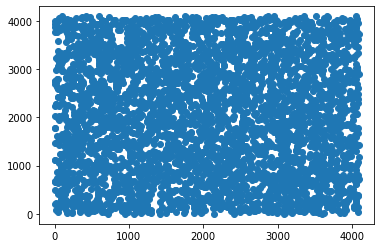

In [2]:
a = np.zeros(4096)
b = np.zeros(4096)
for i in np.arange(a.size):
    a[i], b[i] = random.getrandbits(12), random.getrandbits(12)
print(a)
print(b)
plt.scatter(a,b)

<h3>And also let us check if the same seed generates the same number.</h3>

<p>If we run the cell below over and over again, we will see it generates the same result. Therefore our seed also works.</p>

In [3]:
seed = 1001
random.seed(seed)
print(random.getrandbits(5)) # Generates 5 bits i.e. generates in the (0,32) interval
print(random.getrandbits(6)) # Generates 6 bits i.e. generates in the (0,64) interval
print(random.getrandbits(7)) # Generates 7 bits i.e. generates in the (0,128) interval

25
59
7


<h3>Now we can start writing our IsingLattice class</h3>

In [4]:
class IsingLattice:
    
    # Initializer. Parameter n corresponds to the lattice size. 
    
    def __init__(self,lattice_size,J,h):
        
        # In order to easily access the parameters: 
        self.lattice_size = lattice_size
        self.num_sites = lattice_size*lattice_size
        self.J = J
        self.h = h
        
        # We randomly initialize the lattice with 0's and 1's
        lattice_state = np.random.choice([1,-1],size=(self.lattice_size,self.lattice_size))
        
        # We store the configuration 
        self.lattice_state = lattice_state
    
    # The Methods 
    # Plot function. This will help us easily see the lattice configuration.
    
    def plot_lattice(self, print_info=False): # print_info is Boolean. If it is true then we print info.
        
        plt.figure()
        plt.imshow(self.lattice_state)
        plt.show()
        if print_info==True:
            self.print_info()
    
    # Now we define print_info() method. It will print all the information about the lattice.
    
    def print_info(self):
        
        print("Lattice size: ", self.lattice_size , "x", self.lattice_size, ". J: ", self.J, " h: ", self.h )
    
    # A spin flipper at site (i,j) method
    
    def flip_spin(self,i,j):
        self.lattice_state[i,j] *= -1
        
    # Calculating energy of one spin at site (i,j)
        
    def spin_energy(self,i,j):
        
        # Spin at (i,j)
        spin_ij = self.lattice_state[i,j]
        
        # Now we need to deal with the boundary spins. 
        # We apply periodic boundary conditions.  
        sum_neighbouring_spins = self.lattice_state[(i+1)%self.lattice_size, j] + \
                                 self.lattice_state[i, (j+1)%self.lattice_size] + \
                                 self.lattice_state[(i-1)%self.lattice_size, j] + \
                                 self.lattice_state[i, (j-1)%self.lattice_size]
        
        # We calculate the energy terms for site 
        interaction_term = (- self.J * spin_ij * sum_neighbouring_spins)
        
        # This part is added so that in case 
        # there is no external magnetic field, i.e. h = 0
        # then we do not need the computer to do the computation
        # for the magnetic term. 
        if self.h == 0:
            return interaction_term
        else:
            magnetic_field_term = - (self.h * spin_ij)
            return magnetic_field_term + interaction_term
    
    # Calculating Total Lattice Energy
    
    def energy(self):
        
        # Initialize energy as 0.
        E = 0.0
        
        # We iterate through the lattice
        for i in np.arange(self.lattice_size):
            for j in np.arange(self.lattice_size):
                E = E + self.spin_energy(i,j)
                
        # But we counted neighbours twice here. So we need to correctly return. 
        # We divide by two 
        E = E / (2.0) / self.num_sites
        if self.h==0:
            return E
        else: 
            # We add the magnetic field term |IS THERE A 1/2 FACTOR HERE?|
            E = (E - self.h * np.sum(self.lattice_state)) / self.num_sites
            return E
    
    # Net magnetization
    
    def magnetization(self):
        return  np.abs(np.sum(self.lattice_state))/ (self.num_sites)
        

In [5]:
test = IsingLattice(32,1,0)

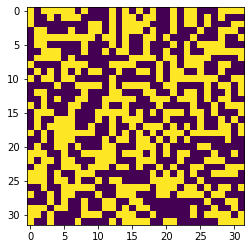

Lattice size:  32 x 32 . J:  1  h:  0


In [6]:
test.plot_lattice(print_info=True)

In [7]:
print(test.magnetization())

0.033203125


<h2>Metropolis Algorithm</h2>

<p>Now that we can see that the IsingModel class works, we can focus on the Metropolis Algorithm step. First we create a method to scan the lattice and make a decision on whether to flip spins one by one. Then we write the main Metropolis method. Below we can see the flowchart explaining the Metropolis algorithm.</p>
<img src="metropolis_flowchart.png" width="50%" height="50%">

<h3>Up until this point, we did the following steps succesfully: we have the lattice inputs, we generated random lattice. Next we will iterate randomly over the matrix and flip spins according to the Metropolis Criteria.</h3>

In [8]:
# Boltzmann constant is fixed to 1.

def scan_lattice(ising_lattice, T):
    
    for k in np.arange(ising_lattice.num_sites):
        # We choose a random site
        lattice_size_power = int(np.log2(ising_lattice.lattice_size))
        i = random.getrandbits(lattice_size_power)
        j = random.getrandbits(lattice_size_power)

        
        # We calculate the energy difference if we flip
        E_initial = ising_lattice.spin_energy(i,j)
        ising_lattice.flip_spin(i,j)
        E_final = ising_lattice.spin_energy(i,j)
        delta_E = E_final - E_initial
        
        # For convenience we flip it back to the original
        ising_lattice.flip_spin(i,j)
        
        # Reminder: Metropolis Algorithm suggests 
        # if delta_E<0 or the Metropolis criterion holds DELTA_E CONDITION IS ERASED FOR TRIAL
        # Then we should flip the spin
        
        if delta_E<0 or np.random.rand()<np.exp(-delta_E/T):
            # If the Metropolis Criteria holds, swap. 
                ising_lattice.flip_spin(i,j)
    

<h3>Now that we have the methods to do the scan, we can collect the data. The whole process will be one method. We will basically do the Monte-Carlo Simulation in the next method using the above scan_lattice. We will collect the data we need.</h3>

In [9]:
def monte_carlo_simulation(ising_lattice, T, num_scans, num_scans_4_equilibrium, frequency_sweeps_to_collect_magnetization, plot_result = False,print_info=False):
    start_time = time.time()
    
    # The first three arguments are self-explanatory. 
    # The last one is the number of scans we need to do
    # Before we reach equilibrium. Therefore we do not
    # need to collect data at these steps. 
    if print_info:
        ising_lattice.print_info()
    
    # We start by collecting <E> and <m> data. In order to 
    # calculate these, we record energy and magnetization 
    # after we reach equilibrium.
    TOTAL_NUM_RECORDS = int(num_scans/frequency_sweeps_to_collect_magnetization)
    energy_records = 0
    magnetization_records = 0
    
    for equ in np.arange(num_scans_4_equilibrium):
        scan_lattice(ising_lattice,T)

    for k in np.arange(num_scans):
        scan_lattice(ising_lattice, T)
        if k%frequency_sweeps_to_collect_magnetization==0:
            energy_records += ising_lattice.energy()
            magnetization_records += ising_lattice.magnetization()
 
    # Now we can get the <E> and <m>
    coefficient_mean = (1/TOTAL_NUM_RECORDS)
    
    # Note that for convenience this is average energy PER SPIN
    mean_energy = coefficient_mean * energy_records
    # Similarly this is average magnetization per spin
    mean_magnetization = coefficient_mean * magnetization_records
    
    
    print(" <E> = ", mean_energy, "<m> = ", mean_magnetization, "for T = ", T, "Simulation is executed in: ", " %s seconds " % round(time.time() - start_time,2))
    
    if plot_result:
        ising_lattice.plot_lattice()
    
    
    return ising_lattice, mean_energy, mean_magnetization

<h3>Before we collect data, let us create a file name generator so that we can easily write our data into files.</h3>

<p>Below we have the file name generator. We will use this when saving our data.</p>

In [10]:
def file_name(lattice_size,J,h,T,seed):
    return f'SQ_L_{lattice_size}_J_{J:.2f}_h_{h:.2f}_T_{T}_s_{seed}'

<h3>Now let us create the functions to write and read the files.</h3>

In [11]:
def write_to_sub_directory(quantity, file_name):
    # Let us check if the path to data exists
    if not(os.path.exists("ising_data")):
        os.mkdir("ising_data")        
    
    # We change directories accordingly
    os.chdir("ising_data")
    if not(os.path.exists(file_name)):
        os.mkdir(file_name)
    os.chdir(file_name)
    
    # Now save with pickle
    file_name_pkl = file_name + ".pkl"
    open_file = open(file_name_pkl,"wb")
    pkl.dump(quantity, open_file)
    open_file.close()
    
    # We go up into the original directory
    os.chdir('..')
    os.chdir('..')

In [12]:
def save_image_to_sub_directory(data,file_name):
    
    # Let us check if the path to data exists
    if not(os.path.exists("ising_data")):
        os.mkdir("ising_data")
    
    # We change directories accordingly
    os.chdir("ising_data")
    
    # We check if it exists, if not we make directory
    if not(os.path.exists(file_name)):
        os.mkdir(file_name)
    os.chdir(file_name)
    
    # Now save image
    file_name_img = file_name + ".png"
    imageio.imwrite(file_name_img, data)
    
    # We go up into the original directory
    os.chdir('..')
    os.chdir('..')

#### UNDER CONSTRUCTION #####

def read_data(lattice_size, J,h,T_init,T_final,seed,num_samples):
    num_directories = sum(os.path.isdir(i) for i in os.listdir(path))
    scale_up_T_init = T_init * TEMPERATURE_SCALE
    scale_up_T_final = T_final * TEMPERATURE_SCALE
    
    try:
        os.chdir("ising_data")
    except:
        print("There is no directory named 'ising_data' ")
        
    for temp in np.arange(num_directories):
        file_name = file_name(lattice_size,J,h, , seed)
        if not(os.path.exists(file_name)):
            


<h3>Now we can write the function for data collection.</h3>

In [14]:
def collect_monte_carlo_data(lattice_size,J,h, T_initial, T_final, T_increment, num_scans, num_scans_4_equilibrium, frequency_sweeps_to_collect_magnetization):

    print("Lattice size: ", lattice_size , "x", lattice_size, ". J: ", J, " h: ", h , "\n")
    
    # Let's scale it up
    # T array is going to be then
    T = np.arange(T_initial*TEMPERATURE_SCALE, (T_final+T_increment)*TEMPERATURE_SCALE, T_increment*TEMPERATURE_SCALE).astype(int)
    
    # Number of samples are calculated
    # since we take one sample for each T
    NUM_SAMPLES = T.size
    
    # Create an array to store average magnetizations
    # with the size NUM_SAMPLES
    mean_magnetizations = np.zeros(NUM_SAMPLES)
    mean_energies = np.zeros(NUM_SAMPLES)
    lattice_configurations = np.zeros((NUM_SAMPLES, lattice_size, lattice_size))

    # We run through T's 
    for i in np.arange(NUM_SAMPLES):
        file_name_lattice = file_name(lattice_size,J,h,T[i],seed)
        path = "ising_data/" + file_name_lattice
        scale_down_T = T[i]/TEMPERATURE_SCALE
        if os.path.exists(path):
            print("Simulation ", i+1, "/", NUM_SAMPLES, ": ", "T = ", scale_down_T, " Already exists!")
            continue
        print("Simulation ", i+1, "/", NUM_SAMPLES, ": ")
        # Each time generate a new random initial lattice configuration
        ising_lattice = IsingLattice(lattice_size, J,h)
        # Now we go through with the Monte-Carlo Simulation
        final_lattice, mean_energy_at_T, mean_magnetization_at_T = monte_carlo_simulation(ising_lattice,scale_down_T,num_scans,num_scans_4_equilibrium,frequency_sweeps_to_collect_magnetization)
                
        # We write these down to a file
        # We create a dictionary with the following key-value pairs
        data_sample = {'lattice_configuration' : final_lattice.lattice_state,
                       'magnetization' : mean_magnetization_at_T,
                       'energy' : mean_energy_at_T}
        
        write_to_sub_directory(data_sample,file_name_lattice)
        save_image_to_sub_directory(final_lattice.lattice_state.astype(np.uint8), file_name_lattice)
       
        

In [17]:
collect_monte_carlo_data(lattice_size=4,J=1.0,h=0.0, T_initial=1.510, T_final=1.534, T_increment=0.001, num_scans=1000, num_scans_4_equilibrium=1000, frequency_sweeps_to_collect_magnetization=35)

Lattice size:  4 x 4 . J:  1.0  h:  0.0 

Simulation  1 / 25 : 
 <E> =  -1.8928571428571428 <m> =  0.9776785714285714 for T =  1.51 Simulation is executed in:   0.49 seconds 
Simulation  2 / 25 : 
 <E> =  -2.026785714285714 <m> =  1.0223214285714286 for T =  1.511 Simulation is executed in:   0.5 seconds 
Simulation  3 / 25 : 
 <E> =  -2.026785714285714 <m> =  1.0223214285714286 for T =  1.512 Simulation is executed in:   0.47 seconds 
Simulation  4 / 25 : 
 <E> =  -2.0357142857142856 <m> =  1.0267857142857142 for T =  1.513 Simulation is executed in:   0.49 seconds 
Simulation  5 / 25 : 
 <E> =  -1.9642857142857142 <m> =  1.0044642857142856 for T =  1.514 Simulation is executed in:   0.48 seconds 
Simulation  6 / 25 : 
 <E> =  -2.017857142857143 <m> =  1.0223214285714286 for T =  1.515 Simulation is executed in:   0.47 seconds 
Simulation  7 / 25 : 
 <E> =  -2.0 <m> =  1.0178571428571428 for T =  1.516 Simulation is executed in:   0.47 seconds 
Simulation  8 / 25 : 
 <E> =  -1.9732142

<h3>Now let us check if we can read the files we have written.</h3>

<p>We can see that the read magnetizations file is the same as the above data; we have succesfully written and read the files.</p>